Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking
using CmdStan, StanMCMCChain
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "chapters", "04")
cd(ProjDir)

### snippet 4.38

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


Define the Stan language model

In [5]:
weightsmodel = "
data {
 int < lower = 1 > N;
 vector[N] height;
 vector[N] weight;
}

parameters {
 real alpha;
 real beta;
 real < lower = 0, upper = 50 > sigma;
}

model {
  # priors
  alpha ~ normal(178, 100);
  beta ~ normal(0, 10);
  sigma ~ uniform(0, 50);
  # model
  height ~ normal(alpha + beta*weight , sigma);
}

generated quantities {
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [6]:
stanmodel = Stanmodel(name="weights", monitors = ["alpha", "beta", "sigma"],
  model=weightsmodel, output_format=:mcmcchain);
# Input data for cmdstan
weightsdata = [
  Dict("N" => length(df2[:height]), "height" => df2[:height], "weight" => df2[:weight])
];

=====> /Users/rob/.julia/dev/StatisticalRethinking/chapters/04


File /Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights.stan will be updated.



Sample using cmdstan

In [7]:
rc, chn, cnames = stan(stanmodel, weightsdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)



--- Translating Stan model to C++ code ---
bin/stanc  /Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights.stan --o=/Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights.hpp
Model name=weights_model
Input file=/Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights.stan
Output file=/Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights.hpp

--- Linking C++ model ---
clang++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.66.0 -isystem stan/lib/stan_math/lib/sundials_3.1.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -DNO_FPRINTF_OUTPUT -pipe   src/cmdstan/main.cpp  -O3 -o /Users/rob/.julia/dev/StatisticalRethinking/chapters/04/tmp/weights -

Compare with a previous result

In [8]:
clip_38s_example_output = "

Samples were drawn using hmc with nuts.
For each parameter, N_Eff is a crude measure of effective sample size,
and R_hat is the potential scale reduction factor on split chains (at
convergence, R_hat=1).

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
          Mean         SD       Naive SE       MCSE     ESS
alpha 113.82267275 1.89871177 0.0300212691 0.053895503 1000
 beta   0.90629952 0.04155225 0.0006569987 0.001184630 1000
sigma   5.10334279 0.19755211 0.0031235731 0.004830464 1000

Quantiles:
          2.5%       25.0%       50.0%       75.0%       97.5%
alpha 110.1927000 112.4910000 113.7905000 115.1322500 117.5689750
 beta   0.8257932   0.8775302   0.9069425   0.9357115   0.9862574
sigma   4.7308260   4.9644050   5.0958800   5.2331875   5.5133417
sigma   3.9447100   4.1530675   4.254755   4.36483000   4.5871028
";

Plot the density of posterior draws

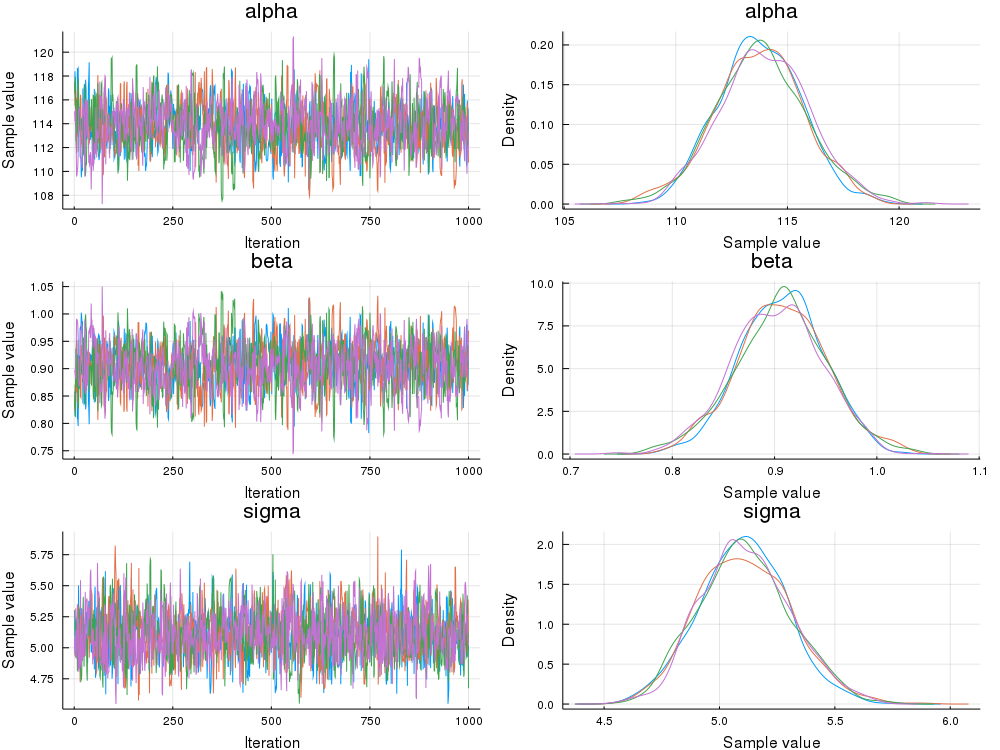

In [9]:
plot(chn)

Plot regression line using means and observations

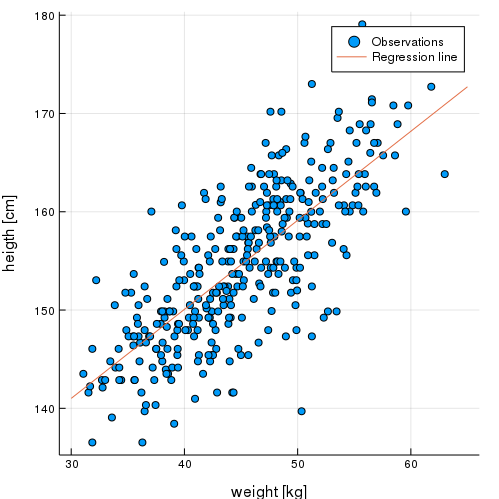

In [10]:
xi = 30.0:0.1:65.0
rws, vars, chns = size(chn[:, 1, :])
alpha_vals = convert(Vector{Float64}, reshape(chn.value[:, 1, :], (rws*chns)))
beta_vals = convert(Vector{Float64}, reshape(chn.value[:, 2, :], (rws*chns)))
yi = mean(alpha_vals) .+ mean(beta_vals)*xi

scatter(df2[:weight], df2[:height], lab="Observations",
  xlab="weight [kg]", ylab="heigth [cm]")
plot!(xi, yi, lab="Regression line")

End of `clip_38.1s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*